# A 90° Bend

We'll start a new simulation where we look at the fields propagating through a waveguide bend, and we'll do a couple of other things differently as well. 

As usual, the first thing to do is to load the Meep library:

In [1]:
import meep as mp
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Video

%matplotlib inline

Using MPI version 3.1, 1 processes


Then let's set up the bent waveguide in a slightly larger cell:

In [2]:
cell = mp.Vector3(16, 16, 0)
geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, -3.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 12, mp.inf),
        center=mp.Vector3(3.5, 2),
        material=mp.Medium(epsilon=12),
    ),
]
pml_layers = [mp.PML(1.0)]
resolution = 10

Note that we have two blocks, both off-center to produce the bent waveguide structure pictured below. As illustrated in the figure, the origin (0,0) of the coordinate system is at the center of the cell, with positive $y$ being downwards, and thus the block of size 12$\times$1 is centered at (-2,-3.5). Also shown in green is the source plane at $x=−7$ which is shifted to $y=−3.5$ so that it is still inside the waveguide.

There are a couple of items to note. First, a point source does not couple very efficiently to the waveguide mode, so we'll expand this into a line source, centered at (-7,-3.5), with the same width as the waveguide by adding a `size` property to the source. This is shown in green in the figure above. An eigenmode source can also be used which is described in Tutorial/Optical Forces. Second, instead of turning the source on suddenly at t=0 which excites many other frequencies because of the discontinuity, we will ramp it on slowly. Meep uses a hyperbolic tangent (tanh) turn-on function over a time proportional to the `width` of 20 time units which is a little over three periods. Finally, just for variety, we'll specify the vacuum wavelength instead of the frequency; again, we'll use a wavelength such that the waveguide is half a wavelength wide.

In [3]:
sources = [
    mp.Source(
        mp.ContinuousSource(wavelength=2 * (11**0.5), width=20),
        component=mp.Ez,
        center=mp.Vector3(-7, -3.5),
        size=mp.Vector3(0, 1),
    )
]

Now we'll set up and visualize the simulation domain.

In [4]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

-----------
Initializing structure...
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (3.5,2,0)
          size (1,12,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


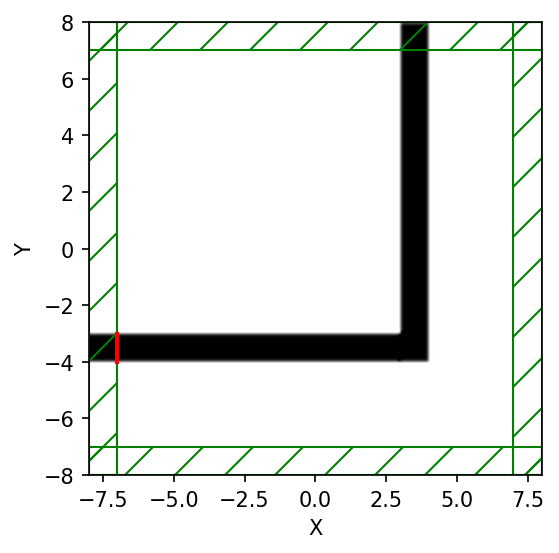

In [5]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

As we expect, we see the bent waveguide structure with PML boundaries (green) and a source (red) with the same size as the waveguide width.

In [6]:
f = plt.figure(dpi=150)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
sim.run(mp.at_every(0.5, Animate), until=100)
plt.close()

Normalizing field data...
run 0 finished at t = 100.0 (2000 timesteps)


In [7]:
filename = "media/bent_waveguide.mp4"
fps = 10
Animate.to_mp4(fps, filename)
Video(filename)

Generating MP4...


It is clear that the transmission around the bend is rather low for this frequency and structure — both large reflection and large radiation loss are clearly visible. Moreover, since we are operating just barely below the cutoff for single-mode behavior, we are able to excite a second leaky mode after the waveguide bend, whose second-order mode pattern (superimposed with the fundamental mode) is apparent in the animation. 

Below, we show a field snapshot from a simulation with a larger cell along the y direction, in which you can see that the second-order leaky mode decays away, leaving us with the fundamental mode propagating upward.

-----------
Initializing structure...
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (3.5,17,0)
          size (1,42,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
Meep progress: 307.35/400.0 = 76.8% done in 4.0s, 1.2s to go
run 1 finished at t = 400.0 (8000 timesteps)


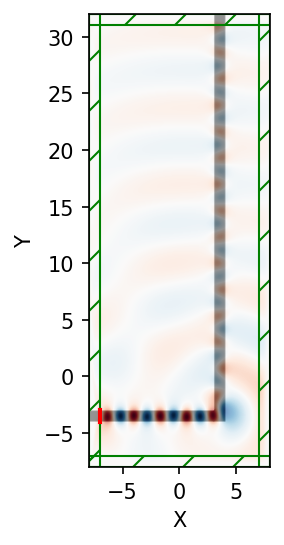

In [8]:
sim.reset_meep()
cell = mp.Vector3(16, 40, 0)
geometry = [
    mp.Block(
        mp.Vector3(12, 1, mp.inf),
        center=mp.Vector3(-2.5, -3.5),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(1, 42, mp.inf),
        center=mp.Vector3(3.5, 17),
        material=mp.Medium(epsilon=12),
    ),
]
sim.cell_size = cell
sim.geometry = geometry
sim.geometry_center = mp.Vector3(0, 12, 0)

sim.run(until=400)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

Instead of doing an animation, another interesting possibility is to make an image from a $x\times t$ slice. To get the $y=−3.5$ slice, which gives us an image of the fields in the first waveguide branch as a function of time, we can use `get_array` in a step function to collect a slice for each time step

-----------
Initializing structure...
     block, center = (-2.5,-3.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (3.5,17,0)
          size (1,42,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
run 2 finished at t = 200.0 (4000 timesteps)


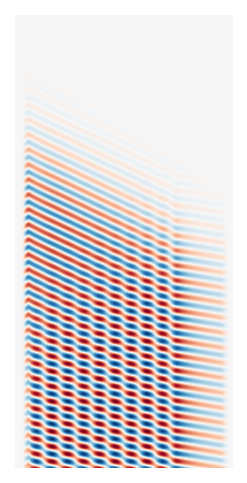

In [9]:
vals = []


def get_slice(sim):
    vals.append(
        sim.get_array(
            center=mp.Vector3(0, -3.5), size=mp.Vector3(16, 0), component=mp.Ez
        )
    )


sim.reset_meep()
sim.run(mp.at_beginning(mp.output_epsilon), mp.at_every(0.6, get_slice), until=200)

plt.figure(dpi=150)
plt.imshow(vals, interpolation="spline36", cmap="RdBu")
plt.axis("off")
plt.show()